In [1]:
import torch, torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tqdm
import os

This notebook accompanies the [week15] practice. Refer to the classwork for more details.


Your last and ultimate task is to implement and train __Convolutional Conditional VAE__. Simple VAE is available in week 15. For details about conditional VAE one can refer to [week 15 lecture](https://github.com/girafe-ai/ml-mipt/tree/advanced/week15_generative) or [this habr post (ru)](https://habr.com/ru/post/331664/)

If it seems too easy, you can use [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset instead of MNIST.

The code in general duplicates the one from the in-class practice. 

Do not forget to __use GPU acceleration during training__.

In [2]:
%matplotlib inline

In [3]:
from torchsummary import summary
import seaborn as sns
sns.set()

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

__Currently you are using device:__

In [5]:
print(device)

cuda:0


In [6]:
# It's dangerous to walk alone. Take these ;)

class Rescale(object):
    def __call__(self, image):
        image = image - image.min()
        image = image/image.max()

        return image
    
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.flatten(x, start_dim=1, end_dim=-1)


class RestoreShape(nn.Module):
    def __init__(self, initial_shape):
        super().__init__()
        self.initial_shape = initial_shape
        
    def forward(self, x):
        return x.view([-1]+list(self.initial_shape))

__Data loading stuff is done for you ;)__

In [7]:
mnist_transformations = transforms.Compose([
    transforms.ToTensor(),
    Rescale()
])

In [8]:
BATCH_SIZE = 256
SHUFFLE_DATASET = True
NUM_DATALOADER_WORKERS = 1

In [9]:
data_root = './'

In [10]:
train_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=True,
        transform=mnist_transformations,
        download=True
    ),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DATASET,
    num_workers=NUM_DATALOADER_WORKERS
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [11]:
test_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=False,
        transform=mnist_transformations
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS
)

__The code below is simple VAE. Your task is to make in convolutional (both encoder and decoder) and add class label information.__

In [12]:
example_batch = next(iter(train_loader))
example_batch = [x.to(device) for x in example_batch]
example_x = example_batch[0][0]

In [16]:
example_batch[0].shape

torch.Size([256, 1, 28, 28])

In [34]:
class ConvolutionalCVAE(nn.Module):
    def __init__(self, intermediate_dims, latent_dim, input_shape):
        super().__init__()
        self.register_buffer('_initial_mu', torch.zeros((latent_dim)))
        self.register_buffer('_initial_sigma', torch.ones((latent_dim)))

        self.latent_distribution = torch.distributions.normal.Normal(
            loc=self._initial_mu,
            scale=self._initial_sigma
        )
        self.encoder = nn.Sequential(*[
            nn.Conv2d(1, intermediate_dims[0], 3, padding=1),
            nn.BatchNorm2d(intermediate_dims[0]),
            nn.ReLU(),

            nn.Conv2d(intermediate_dims[0], intermediate_dims[1], 3, padding=1),
            nn.BatchNorm2d(intermediate_dims[1]),
            nn.ReLU(),

            Flatten(),
        ])
        
        self.mu_repr = nn.Linear(intermediate_dims[1]*28*28, latent_dim)
        self.log_sigma_repr = nn.Linear(intermediate_dims[1]*28*28, latent_dim)
        
        self.decoder = nn.Sequential(*[
            nn.Linear(latent_dim, intermediate_dims[1]*28*28),
            RestoreShape([intermediate_dims[1], 28, 28]),
            nn.Conv2d(intermediate_dims[1], intermediate_dims[1], 3, padding=1),
            nn.BatchNorm2d(intermediate_dims[1]),
            nn.LeakyReLU(),
            nn.Conv2d(intermediate_dims[1], intermediate_dims[0], 3, padding=1),
            nn.BatchNorm2d(intermediate_dims[0]),
            nn.ReLU(),

            nn.Conv2d(intermediate_dims[0], 1, 3, padding=1),
            nn.Sigmoid(),
        ])
    
    def _encode(self, x):
        latent_repr = self.encoder(x)
        mu_values = self.mu_repr(latent_repr)
        log_sigma_values = self.log_sigma_repr(latent_repr)
        return mu_values, log_sigma_values, latent_repr
    
    def _reparametrize(self, sample, mu_values, log_sigma_values):
        latent_sample = torch.exp(log_sigma_values) * sample + mu_values
        return latent_sample

    def forward(self, x, raw_sample=None):
        mu_values, log_sigma_values, latent_repr = self._encode(x)

        if raw_sample is None:
            raw_sample = torch.randn_like(mu_values)

        latent_sample = self._reparametrize(raw_sample, mu_values, log_sigma_values)
        
        reconstructed_repr = self.decoder(latent_sample)
        
        return reconstructed_repr, latent_sample, mu_values, log_sigma_values

In [35]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    fig = plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

#     plt.show()
    return fig


In [36]:
example_batch[0][:15].shape

torch.Size([15, 1, 28, 28])

In [37]:
example_batch = next(iter(train_loader))
example_batch = [x.to(device) for x in example_batch]
example_x = example_batch[0][0]

model = ConvolutionalCVAE([256, 128], 2, example_x.shape).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = torch.nn.modules.loss.BCELoss()

reconstructed_repr, latent_sample, mu_values, log_sigma_values = model(example_batch[0][:15].to(device))

summary(model, example_x.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 28, 28]           2,560
       BatchNorm2d-2          [-1, 256, 28, 28]             512
              ReLU-3          [-1, 256, 28, 28]               0
            Conv2d-4          [-1, 128, 28, 28]         295,040
       BatchNorm2d-5          [-1, 128, 28, 28]             256
              ReLU-6          [-1, 128, 28, 28]               0
           Flatten-7               [-1, 100352]               0
            Linear-8                    [-1, 2]         200,706
            Linear-9                    [-1, 2]         200,706
           Linear-10               [-1, 100352]         301,056
     RestoreShape-11          [-1, 128, 28, 28]               0
           Conv2d-12          [-1, 128, 28, 28]         147,584
      BatchNorm2d-13          [-1, 128, 28, 28]             256
        LeakyReLU-14          [-1, 128,

In [38]:
def kl_loss(mu, log_sigma):
    # YOUR CODE HERE
    # return ...
    sigma = torch.exp(log_sigma)
    return 0.5 * torch.mean(
        torch.sum(mu * mu + sigma - 2 * log_sigma - 1, dim=1)
    )

kl_loss(mu_values, log_sigma_values)

tensor(0.5263, device='cuda:0', grad_fn=<MulBackward0>)

In [39]:
test_batch = next(iter(test_loader))

In [40]:
def get_test_predictions(model, test_loader):
    model.eval()
    reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list = [], [], [], []
    for test_batch in tqdm.tqdm_notebook(test_loader, leave=False):
        out = model(test_batch[0].to(device))
        reconstructed_repr, latent_sample, mu_values, log_sigma_values = [x.detach().cpu() for x in out]
        reconstructed_repr_list.append(reconstructed_repr)
        latent_samples_list.append(latent_sample)
        mu_values_list.append(mu_values)
        log_sigma_values_list.append(log_sigma_values)
    return [
        torch.cat(_list, dim=0)
        for _list in [reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list]
    ]

In [41]:
reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/40 [00:00<?, ?it/s]

In [42]:
n = 15 # to generate image with 15x15 examples
digit_size = 28
latent_dim = 2
from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(model, show=True):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])
            
            z_torch = torch.from_numpy(z_sample).type(torch.FloatTensor).to(device)
            
            x_decoded = model.decoder(z_torch).detach().cpu().numpy()
            digit = x_decoded[0].squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    if show:
        plt.figure(figsize=(15, 15))
        plt.imshow(figure, cmap='Greys_r')
#         plt.grid(None)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
        plt.show()
    return figure

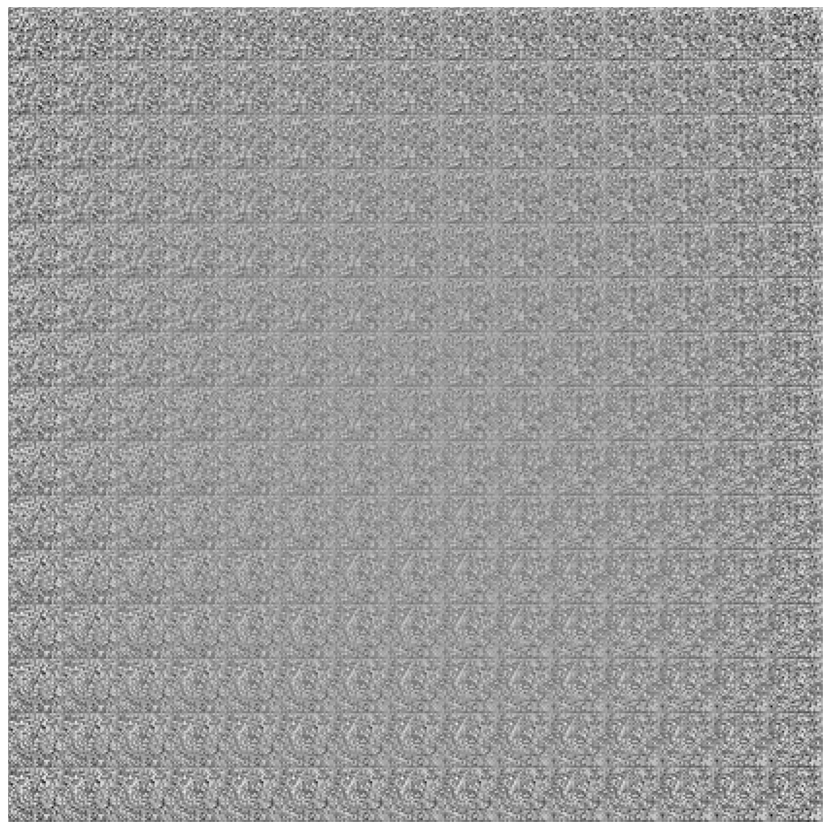

In [43]:
model.eval()
_img = draw_manifold(model, True)

In [44]:
def on_epoch_end(epoch):
    # Saving manifold and z distribution to build plots and animation afterwards
    figure = draw_manifold(model, show=False)
    reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)
    return figure, reconstructed_repr, latent_sample, mu_values, log_sigma_values

In [45]:
def train(num_epochs):
    epochs, figs, latent_distrs = [], [], []
    for epoch_num in tqdm.tnrange(num_epochs):
        model.train()
        loss_accumulator = 0.
        bce_acc = 0.
        kl_acc = 0.
        for batch_x, batch_label in tqdm.tqdm_notebook(train_loader, leave=False):
            batch_x = batch_x.to(device)
            predictions, latent, mu_values, log_sigma_values = model(batch_x)

            kl_loss_ = kl_loss(mu_values, log_sigma_values)
            bce_loss = 28*28*loss_func(predictions, batch_x)
            loss = (bce_loss + kl_loss_)/2./28./28.
            loss.backward()
            opt.step()
            opt.zero_grad()

            loss_accumulator += loss.item()/(len(train_loader.dataset))
            bce_acc += bce_loss.item()/(len(train_loader.dataset))
            kl_acc += kl_loss_.item()/(len(train_loader.dataset))

        if epoch_num % 5 == 0:
            print('Epoch num: {}\nTraining loss={:.4f}, KL divergence={:.4f}, BCE Loss={:.4f}'.format(
                epoch_num,
                loss_accumulator,
                kl_acc,
                bce_acc
            ))
            model.eval()
            figure, reconstructed_repr_test, latent_sample_test, mu_values_test, log_sigma_values_test = on_epoch_end(epoch_num)
            epochs.append(epoch_num)
            figs.append(figure)
            latent_distrs.append((mu_values_test, log_sigma_values_test))
    return epochs, figs, latent_distrs

In [46]:
epochs, figs, latent_distrs = train(50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch num: 0
Training loss=0.0005, KL divergence=0.0214, BCE Loss=0.7813


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch num: 5
Training loss=0.0004, KL divergence=0.0231, BCE Loss=0.6159


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch num: 10
Training loss=0.0004, KL divergence=0.0238, BCE Loss=0.6002


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch num: 15
Training loss=0.0004, KL divergence=0.0245, BCE Loss=0.5960


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch num: 20
Training loss=0.0004, KL divergence=0.0244, BCE Loss=0.5861


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch num: 25
Training loss=0.0004, KL divergence=0.0244, BCE Loss=0.5828


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch num: 30
Training loss=0.0004, KL divergence=0.0245, BCE Loss=0.5792


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch num: 35
Training loss=0.0004, KL divergence=0.0249, BCE Loss=0.5775


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch num: 40
Training loss=0.0004, KL divergence=0.0249, BCE Loss=0.5749


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch num: 45
Training loss=0.0004, KL divergence=0.0249, BCE Loss=0.5709


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

In [47]:
test_labels = []
for b in test_loader:
    test_labels.append(b[1])
test_labels = torch.cat(test_labels, dim=0).numpy()

[gif @ 0x5639c76fa600] GIF muxer supports only a single video GIF stream.
Could not write header for output file #0 (incorrect codec parameters ?): Invalid argument
Error initializing output stream 0:0 -- 



CalledProcessError: ignored

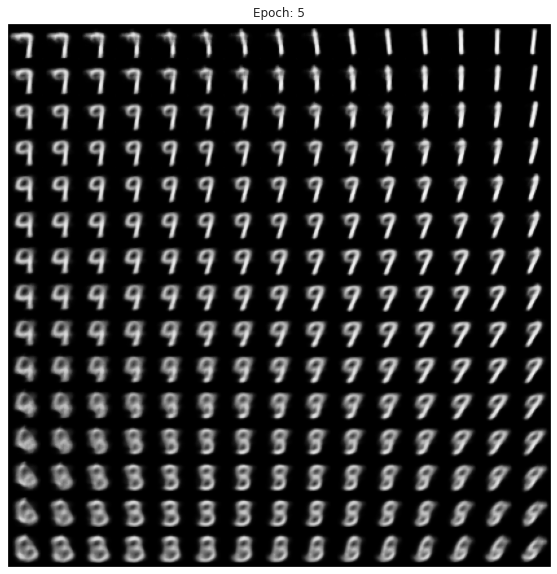

In [54]:
import os
os.makedirs('my_figs', exist_ok=True)

from matplotlib.animation import FuncAnimation
from matplotlib import cm
import matplotlib

def make_2d_figs_gif(figs, epochs, fname, fig): 
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False)
    im = plt.imshow(np.zeros((28,28)), cmap='Greys_r', norm=norm)
    plt.grid(None)
    plt.title("Epoch: " + str(epochs[0]))

    def update(i):
        im.set_array(figs[i])
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        return im
    
    anim = FuncAnimation(fig, update, frames=range(len(figs)), interval=100)
    anim.save(fname, fps=30, writer='ffmpeg')

def make_2d_scatter_gif(zs, epochs, c, fname, fig):
    im = plt.scatter(zs[0][:, 0], zs[0][:, 1], c=c, cmap=cm.coolwarm)
    plt.colorbar()
    plt.title("Epoch: " + str(epochs[0]))
    def update(i):
        fig.clear()
        im = plt.scatter(zs[i][:, 0], zs[i][:, 1], c=c, cmap=cm.coolwarm)
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.set_xlim(-5, 5)
        im.axes.set_ylim(-5, 5)
        return im

    anim = FuncAnimation(fig, update, frames=range(len(zs)), interval=150)
    anim.save(fname, fps=30, writer='ffmpeg')
    
make_2d_figs_gif(figs, epochs, "./my_figs/manifold2.gif", plt.figure(figsize=(10,10)))
make_2d_scatter_gif([x[0].numpy() for x in latent_distrs], epochs, test_labels, "./my_figs/z_distr2.gif", plt.figure(figsize=(10,10)))

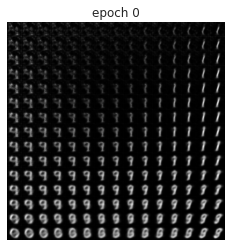

In [59]:
fig = plt.figure()
image_display = plt.imshow(figs[0], cmap='gray')
plt.title(f"epoch {epochs[0]}")


def update(i):
    image_display.set_array(figs[i])
    image_display.axes.set_title(f"epoch {epochs[i]}")
    image_display.axes.axis('off')
    return image_display


anim = FuncAnimation(fig, update, frames=range(len(figs)), interval=100)
anim.save('manifold.mp4', writer='ffmpeg', fps=5)

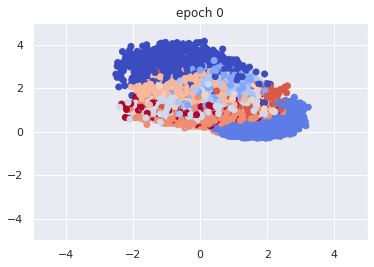

In [61]:
latent_distrs_ = [x[0].numpy() for x in latent_distrs]
test_labels = torch.cat([labels for _, labels in test_loader], dim=0).numpy()
fig = plt.figure()
plt.scatter(
    latent_distrs_[0][:, 0],
    latent_distrs_[0][:, 1],
    c=test_labels,
    cmap='coolwarm',
)
plt.colorbar()
plt.title(f"epoch {epochs[0]}")


def update(i):
    fig.clear()
    plot = plt.scatter(
        latent_distrs_[i][:, 0],
        latent_distrs_[i][:, 1],
        c=test_labels,
        cmap='coolwarm',
    )
    fig.gca().set_title(f"epoch {epochs[i]}")
    fig.gca().set_xlim(-5, 5)
    fig.gca().set_ylim(-5, 5)
    return plot


anim = FuncAnimation(fig, update, frames=range(len(latent_distrs_)), interval=150)
anim.save('distribution.mp4', dpi=80, writer='ffmpeg', fps=5)

You can find your brand gifs in `./my_figs/` directory ;)

Optionally you can also implement GAN for this task. Good luck!